# Реранжирование в рекомендациях с помощью GDBT

## Программа семинара
- Подготовка данных
- Трейн-вал-тест сплит
- Обучаем модель первого уровня
- Генерим кандидатов, которыми дополним датасет ранкера
- Формируем датасет для ранкера
    - Генерим фичи для ранкера
    - Джойним кандидатов и юзер/айтем фичи
- Обучаем ранкер
    - Pointwise
    - Pairwise/Listwise
- Итоговые метрики
- Домашнее задание

## Импорты

In [2]:
import warnings

warnings.simplefilter("ignore")

import dill
import numpy as np
import pandas as pd
import requests
import shap

from lightfm import LightFM
from lightfm.data import Dataset

# from lightgbm import LGBMRanker, LGBMClassifier
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple
from tqdm.auto import tqdm
from zipfile import ZipFile

from tools import generate_lightfm_recs_mapper, avg_user_metric

## Подготовка данных

In [3]:
users = pd.read_csv("../data/users.csv")
items = pd.read_csv("../data/items.csv")
interactions = pd.read_csv("../data/interactions.csv")

In [4]:
print(interactions.shape)
interactions.head(3)

(5476251, 5)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [10]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        "last_watch_dt": Columns.Datetime,
        "watched_pct": Columns.Weight,
    },
    inplace=True,
)
# Меняем тип данных
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format="%Y-%m-%d")

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
    Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.0,
    "total_dur": 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(10)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [12]:
interactions.describe()

,user_id,item_id,datetime,total_dur,weight
count,5.476251e+06,5.476251e+06,5476251,5.476251e+06,5.476251e+06
mean,5.491159e+05,8.485860e+03,2021-06-23 11:56:04.296268032,8.295490e+03,4.636699e+01
min,0.000000e+00,0.000000e+00,2021-03-13 00:00:00,1.000000e+00,0.000000e+00
25%,2.750140e+05,4.326000e+03,2021-05-25 00:00:00,3.710000e+02,4.000000e+00
50%,5.493640e+05,8.776000e+03,2021-07-01 00:00:00,2.898000e+03,3.200000e+01
75%,8.227540e+05,1.254400e+04,2021-07-30 00:00:00,7.116000e+03,1.000000e+02
max,1.097557e+06,1.651800e+04,2021-08-22 00:00:00,8.041167e+07,1.000000e+02
std,3.166077e+05,4.740762e+03,NaN,4.856799e+04,4.191923e+01


In [13]:
print(users.shape)
users.head(3)

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0


In [14]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype("category").cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype("category")
    return df, cat_col_encoding


users_cat_cols = [
    # 'user_id',
    "age",
    "income",
    "sex",
    "kids_flg",
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding["income"], users["income"].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int8): [-1, 0, 1, 2, 3, 4, 5])

In [15]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0


In [16]:
# Наиболее популярны income - income_40_60
users.describe(include="category")

,age,income,sex,kids_flg
count,840197,840197,840197,840197
unique,7,7,3,2
top,1,2,0,0
freq,233926,471519,425270,587209


### `items`: данные об айтемах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова 
- `description` - описание

In [17]:
print(items.shape)
items.head(3)

(15963, 14)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [18]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id',
    "content_type",
    "for_kids",
    "studios",
]
items_text_cols = [
    "title",
    "title_orig",
    "genres",
    "countries",
    "directors",
    "actors",
    "description",
    "keywords",
]
items_num_cols = [
    "release_year",
    "age_rating",
]
default_values_items = {
    "release_year": items["release_year"].median(),
    "age_rating": items["age_rating"].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding["studios"]

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

In [19]:
items.describe(include="all")

,item_id,content_type,release_year,for_kids,age_rating,studios
count,15963.000000,15963.0,15963.000000,15963.0,15963.000000,15963.0
unique,NaN,2.0,NaN,3.0,NaN,39.0
top,NaN,0.0,NaN,-1.0,NaN,-1.0
freq,NaN,12002.0,NaN,15397.0,NaN,14898.0
mean,8268.453424,NaN,2007.969492,NaN,12.945937,NaN
std,4773.841513,NaN,16.835890,NaN,5.495760,NaN
min,0.000000,NaN,1897.000000,NaN,0.000000,NaN
25%,4141.500000,NaN,2007.000000,NaN,12.000000,NaN
50%,8266.000000,NaN,2014.000000,NaN,16.000000,NaN
75%,12414.500000,NaN,2018.000000,NaN,16.000000,NaN


## Трейн-вал-тест сплит

In [20]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")
print(f"Продолжительность: {max_date - min_date}")

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


### Схема валидации с разбиением по юзерам (удобна для первого запуска в  проде)

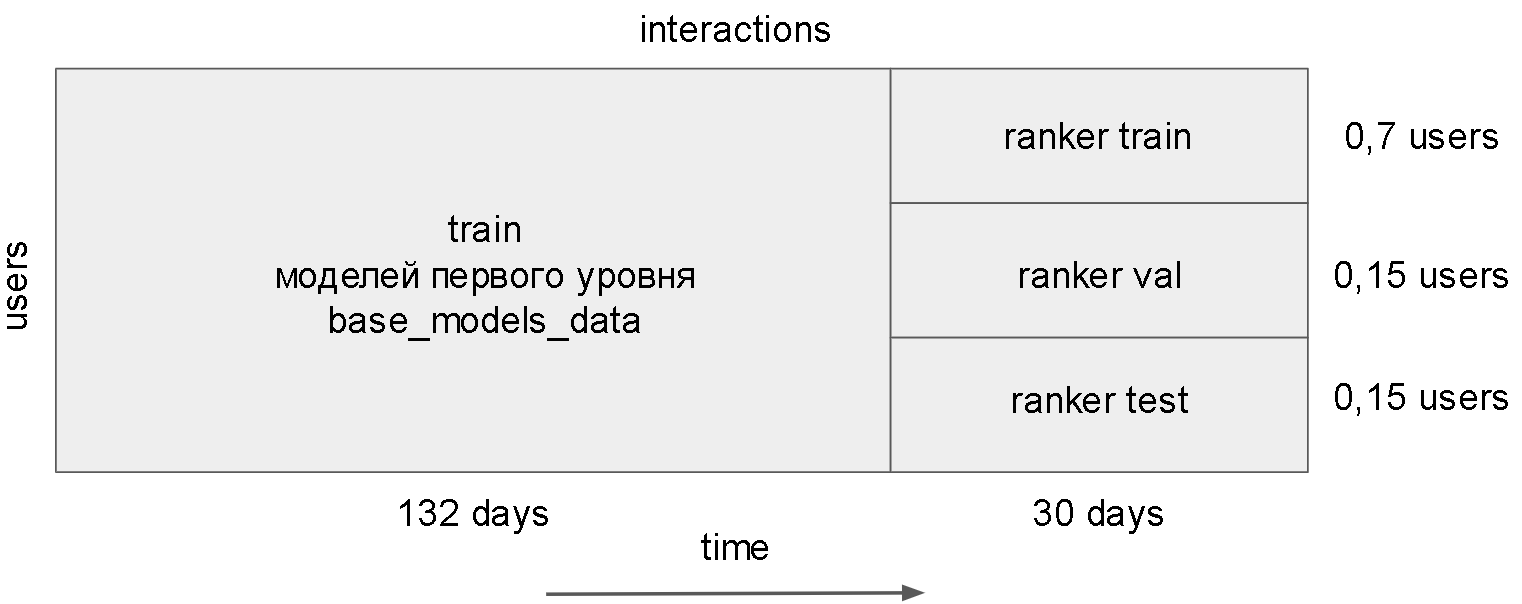

In [21]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[(interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))]

# В дальнейшем ranker_data разбиваем по юзерам
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)

train_val_users, test_users = train_test_split(ranker_data["user_id"].unique(), random_state=42, test_size=test_size)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [22]:
# Для базовых моделей первого уровня (в нашем случае только lightfm)
#  оставим все оставшиеся взаимодействия для обучения

base_models_data = interactions[(interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))]

## Используем предобученную модель превого уровня

In [23]:
lfm_candidates = pd.read_csv("../data/candidates_lfm.csv")

# Popular, как вторая модель первого уровня


In [25]:
from rectools.models import PopularModel
from rectools.dataset import Dataset

dataset = Dataset.construct(base_models_data)
popular_model = PopularModel()
popular_model.fit(dataset)

n_items = items[Columns.Item].nunique()
pop_candidates = popular_model.recommend(dataset.user_id_map.external_ids[:1], dataset, n_items, True)
pop_candidates.rename({"rank": "pop_rank", "score": "pop_score"}, axis=1, inplace=True)
pop_candidates.drop(Columns.User, axis=1, inplace=True)
pop_candidates.head()

,item_id,pop_score,pop_rank
0,10440,141889.0,1
1,15297,137128.0,2
2,13865,93403.0,3
3,4151,69641.0,4
4,2657,55146.0,5


# Объединение предсказаний

In [26]:
candidates = lfm_candidates.merge(pop_candidates, how="left", on=[Columns.Item])
candidates.head()

,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,176549,12365,0.001082,1,521.0,1211.0
1,176549,2150,0.001069,2,14.0,6563.0
2,176549,13865,0.000992,3,93403.0,3.0
3,176549,12138,0.000988,4,1675.0,343.0
4,176549,10440,0.000962,5,141889.0,1.0


# Считаем метрики

In [28]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        "ndcg@10": NDCG(k=10),
        "map@10": MAP(k=10),
        "Precision@10": Precision(k=10),
        "recall@10": Recall(k=10),
        "novelty@10": MeanInvUserFreq(k=10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df.rename(columns={rank_col: Columns.Rank})[[Columns.User, Columns.Item, Columns.Rank]][
                candidates_df[Columns.User].isin(test_users)
            ]
        ),
        interactions=(
            ranker_data[[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]][
                ranker_data[Columns.User].isin(test_users)
            ]
        ),
        prev_interactions=(
            base_models_data[[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]][
                base_models_data[Columns.User].isin(test_users)
            ]
        ),
        catalog=items["item_id"].unique(),
    )


models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics["lfm"] = calc_metrics_(candidates, "lfm_rank")
models_metrics["lfm"]

{'Precision@10': 0.006513898055346646,
 'recall@10': 0.02207127349822488,
 'ndcg@10': 0.006255680840216085,
 'map@10': 0.0057804973625402885,
 'novelty@10': 10.282676460553644}

In [29]:
models_metrics["pop"] = calc_metrics_(candidates, "pop_rank")
models_metrics["pop"]

{'Precision@10': 0.010579712369346001,
 'recall@10': 0.03849818469786577,
 'ndcg@10': 0.01703404691581336,
 'map@10': 0.02536087006498902,
 'novelty@10': 2.089106377567239}

### Генерим фичи для ранкера

In [30]:
# Получаем длину истории юзера
base_models_data["user_hist"] = base_models_data.groupby("user_id")["item_id"].transform("count")
# Получаем популярность контента
base_models_data["item_pop"] = base_models_data.groupby("item_id")["user_id"].transform("count")
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data["user_avg_pop"] = base_models_data.groupby("user_id")["item_pop"].transform("mean")
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data["item_avg_hist"] = base_models_data.groupby("item_id")["user_hist"].transform("mean")
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data["user_last_pop"] = base_models_data.groupby("user_id")["item_pop"].transform("first")
base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


In [31]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items,
    right=(base_models_data[["item_id", "item_pop", "item_avg_hist"]].drop_duplicates()),
    how="left",
    on="item_id",
)

users = pd.merge(
    left=users,
    right=(base_models_data[["user_id", "user_hist", "user_avg_pop", "user_last_pop"]].drop_duplicates()),
    how="left",
    on="user_id",
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN


In [32]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно,
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items["item_pop"] = base_models_data["item_pop"].median()
default_values_items["item_avg_hist"] = base_models_data["item_avg_hist"].median()

# Для новых фичей юзеров
default_values_users = {
    "user_hist": 0,
    "user_avg_pop": base_models_data["user_avg_pop"].median(),
    "user_last_pop": base_models_data["user_last_pop"].median(),
}

### Джойним кандидатов и юзер/айтем фичи

In [34]:
# Загружаем список айтемов-кандидатов.
# Модель lightfm нам больше не понадобится

# candidates = pd.read_csv('../data/candidates.csv')
candidates.head(3)

,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,176549,12365,0.001082,1,521.0,1211.0
1,176549,2150,0.001069,2,14.0,6563.0
2,176549,13865,0.000992,3,93403.0,3.0


In [35]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты


def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df["user_id"].isin(user_list)],
        candidates_df[candidates_df["user_id"].isin(user_list)],
        how="outer",  # right ?
        on=["user_id", "item_id"],
    )
    # Проставляем дефолтные значения интеракций
    min_score: float = df["lfm_score"].min() - 0.01
    max_rank: int = df["lfm_rank"].max() + 1  # 101

    default_values = {
        "lfm_score": min_score,
        "lfm_rank": max_rank,
        # Важно использовате те же дефолтные значения для интеракций,
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    return df


ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank
1180642,3,47,2021-08-16,2179.0,27.0,-0.012017,51.0,NaN,NaN
998971,3,142,2021-08-13,5892.0,100.0,-0.012017,51.0,NaN,NaN
1067328,3,965,2021-08-16,5813.0,96.0,-0.012017,51.0,NaN,NaN


In [36]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(df, users, how="left", on=["user_id"])
    df = pd.merge(df, items, how="left", on=["item_id"])

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df


# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет,
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,47,2021-08-16,2179.0,27.0,-0.012017,51.0,NaN,NaN,-1,...,0.0,11957.864865,2858.0,0,2017.0,-1,18.0,-1,1249.0,38.180144
1,3,142,2021-08-13,5892.0,100.0,-0.012017,51.0,NaN,NaN,-1,...,0.0,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464
2,3,965,2021-08-16,5813.0,96.0,-0.012017,51.0,NaN,NaN,-1,...,0.0,11957.864865,2858.0,0,2018.0,-1,12.0,-1,536.0,29.130597


In [38]:
# Датасеты готовы, остались только таргеты,
# которые можно посчитать на основе колонок total_dur и watched_pct

# Делаем еще один чекпоинт.

# Не пользуемся методом eval если точно не знаем, что за строка.
# Он не безопасен и долго работает.
# Можно заменить на locals()[name]
for name in ["train", "val", "test"]:
    path: str = f"../data/ranker_{name}.csv"
    # eval(f'ranker_{name}').to_csv(path, index=False)
    locals()[f"ranker_{name}"].to_csv(path, index=False)

In [39]:
# Загружаем данные
for name in ["train", "val", "test"]:
    path: str = f"../data/ranker_{name}.csv"
    locals()[f"ranker_{name}"] = pd.read_csv(path)

In [40]:
# таргет бинарный, так что -
# будем считать просмотр хорошим если доля досмотра больше половины


def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df["target"] = df[Columns.Weight] > 50  # 'watched_pct'
    df["target"] = df["target"].astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
0,3,47,2021-08-16,2179.0,27.0,-0.012017,51.0,NaN,NaN,-1,...,11957.864865,2858.0,0,2017.0,-1,18.0,-1,1249.0,38.180144,0
1,3,142,2021-08-13,5892.0,100.0,-0.012017,51.0,NaN,NaN,-1,...,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,1
2,3,965,2021-08-16,5813.0,96.0,-0.012017,51.0,NaN,NaN,-1,...,11957.864865,2858.0,0,2018.0,-1,12.0,-1,536.0,29.130597,1


In [41]:
# В train и val можно удалить 'плохих' пользователей,
# Например тех у кого слишком много или мало просмотров или
# тех для которых нет достаточного количества рекомендаций от LightFM
# Тестовую группу не меняем


def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    groups_df = df[["user_id", "item_id"]].groupby(by=["user_id"]).count().rename(columns={"item_id": "group_size"})
    df = pd.merge(df, groups_df, how="left", on=["user_id"])
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df["group_size"] >= 100]

    # Колонка больше не нужна
    df.drop(columns=["group_size"], inplace=True)
    return df


ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
# ranker_test = filter_group(ranker_test)

In [42]:
# Вспоминаем какие есть колонки
ranker_train.columns

Index(['user_id', 'item_id', 'datetime', 'total_dur', 'weight', 'lfm_score',
       'lfm_rank', 'pop_score', 'pop_rank', 'age', 'income', 'sex', 'kids_flg',
       'user_hist', 'user_avg_pop', 'user_last_pop', 'content_type',
       'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop',
       'item_avg_hist', 'target'],
      dtype='object')

In [43]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    "lfm_score",
    "lfm_rank",
    "age",
    "income",
    "sex",
    "kids_flg",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "content_type",
    "release_year",
    "for_kids",
    "age_rating",
    "studios",
    "item_pop",
    "item_avg_hist",
]
# Из них категориальные:
cat_cols = [
    "age",
    "income",
    "sex",
    "kids_flg",
    "content_type",
    "for_kids",
    "studios",
]

In [81]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f"{name}_score"] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=["user_id", f"{name}_score"],
        ascending=[True, False],
        inplace=True,
    )
    df[f"{name}_rank"] = df.groupby("user_id").cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df["lfm_rank"] < 101).to_numpy()
    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f"{name}_hybrid_score"] = df[f"{name}_score"] * mask
    df[f"{name}_hybrid_score"].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f"{name}_hybrid_rank"] = df[f"{name}_rank"] * mask
    max_rank: int = 101
    df[f"{name}_hybrid_rank"].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df


ranker_test = add_score_and_rank(ranker_test, y_pred, "pointwise")
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank
0,1,3669,2021-08-16,1593.0,26.0,-0.012017,51.0,NaN,NaN,1,...,-1,18.0,-1,2846.0,22.675978,0,0.402558,1,0.402558,1
1,1,10440,2021-08-13,19579.0,80.0,-0.012017,51.0,NaN,NaN,1,...,-1,18.0,-1,141889.0,8.068716,1,0.363104,2,0.363104,2
2,12,846,2021-08-21,5929.0,18.0,-0.012017,51.0,NaN,NaN,-1,...,0,16.0,-1,528.0,22.799242,0,0.267182,1,0.267182,1


In [85]:
def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["lfm_rank"] <= 100]


ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

### Pairwise/Listwise

In [108]:
def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(df[["user_id", "item_id"]].groupby(by=["user_id"]).count()["item_id"])

In [109]:
# Добавим таргет посложнее


def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df["target_ranker"] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df["target_ranker"] += (df[Columns.Weight] >= 75).astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target,target_ranker
6833,858,14,2021-08-07,153.0,0.0,-0.012017,51.0,NaN,NaN,1,...,9473.0,1,2019.0,-1,16.0,-1,5675.0,17.167225,0,0
6834,858,142,2021-07-31,5281.0,100.0,-0.012017,51.0,NaN,NaN,1,...,9473.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,1,2
6835,858,232,2021-08-22,714.0,0.0,-0.012017,51.0,NaN,NaN,1,...,9473.0,1,2003.0,-1,16.0,-1,2846.0,22.675978,0,0


In [111]:
from xgboost import XGBRanker

params = {
    "objective": "rank:ndcg",  # ndcg scorer
    "n_estimators": 10000,  # maximum number of trees
    "max_depth": 4,  # maximum depth of the tree
    "min_child_weight": 100,  # minimum number of instances needed in a child
    "learning_rate": 0.25,  # learning rate
    "reg_lambda": 1,  # L2 regularization
    "colsample_bytree": 0.9,  # fraction of columns used by each tree
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target_ranker"],
    "group": get_group(ranker_train),
    "eval_set": [(ranker_val[cols], ranker_val["target_ranker"])],
    "eval_group": [get_group(ranker_val)],
    "early_stopping_rounds": 32,  # number of rounds without improvement before stopping
    "verbose": 32 // 8,  # frequency of outputting metrics
}

listwise_model = XGBRanker(**params)
listwise_model.fit(**fit_params)

[0]	validation_0-ndcg@32:0.59697
[4]	validation_0-ndcg@32:0.62553
[8]	validation_0-ndcg@32:0.63278
[12]	validation_0-ndcg@32:0.62642
[16]	validation_0-ndcg@32:0.62496
[20]	validation_0-ndcg@32:0.62549
[24]	validation_0-ndcg@32:0.62499
[28]	validation_0-ndcg@32:0.62367
[32]	validation_0-ndcg@32:0.62365
[36]	validation_0-ndcg@32:0.62493
[40]	validation_0-ndcg@32:0.62555


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0.9, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=0.25, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
          max_leaves=None, min_child_weight=100, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=10000,
          n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [112]:
# save model
with open(f"../model_weights/listwise_model.dill", "wb") as f:
    dill.dump(listwise_model, f)

In [115]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, "listwise")
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,pointwise_hybrid_rank,fixed_pointwise_score,fixed_pointwise_rank,fixed_pointwise_hybrid_score,fixed_pointwise_hybrid_rank,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
1,1,10440,2021-08-13,19579.0,80.0,-0.012017,51.0,NaN,NaN,1,...,2,0.363104,2,0.363104,2,2,0.052966,1,0.052966,1
0,1,3669,2021-08-16,1593.0,26.0,-0.012017,51.0,NaN,NaN,1,...,1,0.402558,1,0.402558,1,1,0.011830,2,0.011830,2
2,12,846,2021-08-21,5929.0,18.0,-0.012017,51.0,NaN,NaN,-1,...,1,0.267182,1,0.267182,1,1,-0.263295,1,-0.263295,1


In [116]:
models_metrics["listwise"] = calc_metrics_(ranker_test, "listwise_rank")
models_metrics["listwise_hybrid"] = calc_metrics_(ranker_test, "listwise_hybrid_rank")
pd.DataFrame(models_metrics)[["listwise", "listwise_hybrid"]]

,listwise,listwise_hybrid
Precision@10,0.320846,0.320846
recall@10,0.966863,0.966863
ndcg@10,0.440931,0.440931
map@10,0.952964,0.952964
novelty@10,6.539828,6.539828


In [117]:
(
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),  # target_ranker
        y_pred=np.array(ranker_test["listwise_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["listwise_hybrid_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
)

(0.8253479559938095, 0.8253479559938095)

## Итоговые метрики

In [118]:
pd.DataFrame(models_metrics)[["lfm", "fixed_pointwise_hybrid", "listwise_hybrid"]]

,lfm,fixed_pointwise_hybrid,listwise_hybrid
Precision@10,0.006514,0.320572,0.320846
recall@10,0.022071,0.966721,0.966863
ndcg@10,0.006256,0.439854,0.440931
map@10,0.005780,0.948637,0.952964
novelty@10,10.282676,6.667054,6.539828


In [120]:
ranker_full = pd.concat([ranker_train, ranker_val, ranker_test])
len(ranker_full)

1759275

In [121]:
y_pred: np.ndarray = listwise_model.predict(ranker_full[cols])
ranker_full = add_score_and_rank(ranker_full, y_pred, "listwise")
ranker_full.head()

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,pointwise_hybrid_score,pointwise_hybrid_rank,fixed_pointwise_score,fixed_pointwise_rank,fixed_pointwise_hybrid_score,fixed_pointwise_hybrid_rank,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
1,1,10440,2021-08-13,19579.0,80.0,-0.012017,51.0,NaN,NaN,1,...,0.363104,2.0,0.363104,2.0,0.363104,2.0,0.052966,1,0.052966,1
0,1,3669,2021-08-16,1593.0,26.0,-0.012017,51.0,NaN,NaN,1,...,0.402558,1.0,0.402558,1.0,0.402558,1.0,0.011830,2,0.011830,2
2,12,846,2021-08-21,5929.0,18.0,-0.012017,51.0,NaN,NaN,-1,...,0.267182,1.0,0.267182,1.0,0.267182,1.0,-0.263295,1,-0.263295,1
4,19,8707,2021-08-15,66.0,0.0,-0.012017,51.0,NaN,NaN,-1,...,0.188149,2.0,0.188149,2.0,0.188149,2.0,-0.256409,1,-0.256409,1
5,19,14275,2021-08-15,79.0,1.0,-0.012017,51.0,NaN,NaN,-1,...,0.188149,3.0,0.188149,3.0,0.188149,3.0,-0.256409,2,-0.256409,2


In [122]:
K_RECS = 10
ranker_full = ranker_full[[Columns.User, Columns.Item, "listwise_hybrid_rank"]]
ranker_full = ranker_full.sort_values([Columns.User, "listwise_hybrid_rank"]).groupby(Columns.User).head(K_RECS)
ranker_full.drop("listwise_hybrid_rank", axis=1, inplace=True)
ranker_full.head()

,user_id,item_id
1,1,10440
0,1,3669
2,12,846
4,19,8707
5,19,14275


In [127]:
recos = ranker_full.groupby(Columns.User).agg(list).to_dict()[Columns.Item]

In [128]:
import json

with open("../model_weights/ranker.json", "w") as f:
    json.dump(recos, f)